# Lab 09: MLB Swing Probability Modeling

---
author: Qiran Hu
date: November 15, 2024
embed-resources: true
---

## Introduction

In this research, we aim to develop a predictive model that estimates the probability of a batter swinging at a pitch by utilizing comprehensive baseball pitch data from pitcher Zac Gallen during the 2023 MLB season. . While baseball is fundamentally a team sport, it ultimately revolves around the intricate duel between the pitcher and the batter. The pitcher's objective is to prevent the batter from reaching base by striking them out, inducing ground balls, or causing fly outs. On the other hand, the batter aims to reach base through solid contact or by drawing a walk.

This interaction is both a psychological contest and a physical challenge, where players engage in a strategic battle with each other. Pitchers employ a variety of techniques like different pitch types and spin rates to confuse the batters. For instance, a pitcher might use a fastball to disrupt the batter's timing. Conversely, batters could analyze the pitcher's tendencies, delivery patterns, and situational probabilities to anticipate the next pitch. They could also look for subtle cues in the pitcher's movements or rely on strategic insights to make informed decisions during the game. Depending on the game situation and the characteristics of the pitcher, a pitcher often throws a pitch with the intention to make the batter swing or not. Pitchers want batters to swing at pitches that have a low probability of successful contact, such as those outside the strike zone or with deceptive movement. For instance, a curveball that starts in the strike zone  can confuse the batter. Alternatively, pitchers want batters to take pitches that will be called strikes where pitches are on the edges of the strike zone. 

In fact, modern baseball analytics is focused on studying about how to enhance pitcher development and inform strategic decisions when batters swing at pitches. By understanding these patterns, teams can improve their pitching strategies to exploit batters' weaknesses and increase their overall performance. For example, pitchers can be instructed to target that area , if data shows that a particular batter struggles with high inside fastballs. Thus, our goal is to examine these insights by developing an advanced machine learning model that predicts the likelihood of inducing a batter to swing with detailed information about pitch. we will incorporate variables that the pitcher fully controls which is pitch_name and those that are mostly controlled by the pitcher, such as release_extension, release_pos_x, release_pos_y, and release_pos_z. We will also consider those mechanisms that are somewhat controlled by the pitcher like release_speed, release_spin_rate, and spin_axis as well as the pitch's location at the plate like plate_x and plate_z. Moreover, the model will account for downstream effects of these choices with pitch's movement of pfx_x and pfx_z, which are crucial in deceiving the batter. Furthermore, additional information like the count of balls, strikes, on_1b, on_2b, on_3b, and outs_when_up will also be included to analyze both pitchers and batters during the game.

As data scientists working for a Major League Baseball team in the Research & Development department, we will present this report to the VP of Research & Development, who is a baseball expert familiar with data analysis and machine learning concepts. We aim to demonstrate how this predictive model can be a valuable tool for pitcher development and game strategy optimization. By training our model on Zac Gallen's historical pitches, we can analyze patterns specific to his pitching style. For example, we might find that his curveball has a higher swing probability when thrown low in the zone after a high fastball, which could be helpful to adjust their game strategies and indicate the perfect timing to utilize certain pitches to maximize the likelihood of inducing a swing.

While our model significantly improves the ability to predict swing probabilities based on measurable attributes, it is specialized in this aspect and does not capture other factors such as individual batter tendencies, in game adjustments, or other factors. As one can see, by providing useful insights based on quantifiable data, this model represents a meaningful advancement in incorporating data analytics into baseball strategy so that we can assist pitchers like Zac Gallen in improving their strategies in the near future. 

## Methods

In [1]:
# imports
import numpy as np
import pandas as pd
from joblib import parallel_backend
import seaborn as sns

# data generation and loading
from sklearn.datasets import make_blobs
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# plotting
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import plot_tree
from sklearn.tree import export_text

# basic classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# basic regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

# ensembles for classification
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

# ensembles for regression
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

# model tuning and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV

# model metrics
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    fbeta_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from pprint import pprint
from sklearn.calibration import CalibratedClassifierCV

import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

### Data

In [2]:
# load data
pitches_train = pd.read_csv(
    "https://cs307.org/lab-09/data/pitches-train.csv",
)
pitches_test = pd.read_csv(
    "https://cs307.org/lab-09/data/pitches-test.csv",
)

In [3]:
pitches_train

,pitch_name,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_axis,plate_x,plate_z,...,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,stand,sz_top,sz_bot,swing
0,Cutter,6.6,-2.76,53.86,5.81,92.6,2376.0,195.0,-0.09,2.79,...,3,1,0,0,0,1,L,3.15,1.52,1
1,Changeup,6.8,-2.87,53.74,5.66,86.3,1511.0,226.0,-1.47,1.84,...,2,1,0,0,0,1,L,3.13,1.56,0
2,Changeup,6.7,-2.83,53.82,5.68,87.9,1570.0,224.0,-1.52,2.38,...,1,1,0,0,0,1,L,3.12,1.51,0
3,Knuckle Curve,6.7,-2.70,53.78,5.78,82.4,2398.0,32.0,0.20,1.04,...,1,0,0,0,0,1,L,3.15,1.52,1
4,Cutter,6.7,-2.64,53.83,5.81,91.0,2427.0,189.0,0.89,1.65,...,0,0,0,0,0,1,L,3.12,1.51,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2648,4-Seam Fastball,6.8,-2.64,53.75,5.99,93.4,2411.0,206.0,0.59,2.91,...,0,0,0,0,0,1,L,3.50,1.81,0
2649,Slider,6.3,-2.91,54.19,5.86,87.3,2541.0,113.0,1.38,1.73,...,1,2,0,0,0,0,R,3.19,1.48,1
2650,Knuckle Curve,6.4,-2.91,54.13,5.87,84.7,2539.0,35.0,0.81,0.11,...,1,1,0,0,0,0,R,3.19,1.48,1
2651,4-Seam Fastball,6.4,-2.67,54.13,6.04,94.3,2531.0,201.0,1.05,1.79,...,0,1,0,0,0,0,R,3.03,1.48,0


To achieve the goal of this research, we will need previously thrown pitches. The necessary data is provided in the following files:

pitches-train.csv
pitches-test.csv

### Source
This research will use data from Statcast. We will focus on a model for a specific pitcher, Zac Gallen.

Baseball Reference: Zac Gallen
MLB Savant: Zac Gallen
In this research, the train-test split is done within the 2023 MLB Season. That is, the training data is Zac Gallen pitches that occurred between opening day (2023-03-30) and the trade deadline (2023-08-31). The test data covers the remainder of the season, from September 1 (2023-09-01) to the final day of the regular season (2023-10-02). Hidden from you is the production data which covers the postseason (2023-10-03 to 2023-11-01).

We do this in place of randomly splitting the data in an attempt to create a model that can predict into the future. Imagine this model is created on the final day of the regular season, then possibly used to make baseball decisions during the playoffs.

Because Statcast data can change at any moment, it is constantly changed and improved, we provide a snapshot of the data for use in this research. If you are interested in obtaining similar data for other analyses, we recommend the pybaseball package.

### Data Dictionary
Each observation in the train, test, and (hidden) production data contains information about a pitch thrown by Zac Gallen.

#### Response Variable

**`swing`** - `[int64]` Whether or not the batter swung (1) or took (0).

#### Features Variable

While we will certainly not be able to make any truly causal claims about our model, it is important to understand which variables are controlled by the pitcher. We could imagine a coach using this model to help explain to a pitcher where and how to throw a pitch if they want to induce a swing. As such, we will group the feature variables based on the degree of control the pitcher asserts over them.

##### Fully Pitcher Controlled

This variable is fully controlled by the pitcher. In modern baseball, this information is communicated between the pitcher and catcher before the pitch via PitchCom.

**`pitch_name`** - `[object]` The name of the pitch type to be thrown.

##### Mostly Pitcher Controlled

These variables are largely controlled by the pitcher, but even at the highest levels of baseball, there will be variance based on skill, fatigue, etc. There variables essentially measure where the pitcher’s arm is locations as a pitch is thrown.

**`release_extension`** - `[float64]` Release extension of pitch in feet as tracked by Statcast.

**`release_pos_x`** - `[float64]` Horizontal Release Position of the ball measured in feet from the catcher’s perspective.

**`release_pos_y`** - `[float64]` Release position of pitch measured in feet from the catcher’s perspective.

**`release_pos_z`** - `[float64]` Vertical Release Position of the ball measured in feet from the catcher’s perspective.

##### Somewhat Pitcher Controlled

These variables are in some sense controlled by the pitcher, but less so than the previous variables. At the MLB level, pitchers will have some control here, but even at the highest levels, there can be a lot of variance. The speed and spin features are highly dependent on the pitch type thrown.

**`release_speed`** - `[float64]` Velocity of the pitch thrown.

**`release_spin_rate`** - `[float64]`  Spin rate of pitch tracked by Statcast.

**`spin_axis`** - `[float64]` The spin axis in the 2D X-Z plane in degrees from 0 to 360, such that 180 represents a pure backspin fastball and 0 degrees represents a pure topspin (12-6) curveball.

**`plate_x`** - `[float64]` Horizontal position of the ball when it crosses home plate from the catcher’s perspective.

**`plate_z`** - `[float64]` Vertical position of the ball when it crosses home plate from the catcher’s perspective.

##### Downstream Pitcher Controlled

Theses variables are pitch characteristics, and maybe somewhat controlled by the pitcher, but are largely functions of the previous variables.

**`pfx_x`** - `[float64]` Horizontal movement in feet from the catcher’s perspective.

**`pfx_z`** - `[float64]` Vertical movement in feet from the catcher’s perspective.

##### Situational Information

These variables describe part of the game situation when the pitch was thrown. (We have omitted some other obvious variables here like score and inning for simplicity.) These are fixed before a pitch is thrown, but could have an effect. Pitchers and batters often act differently based on the game situation. For example, batters are known to “protect” when there are two strikes, thus, are much more likely to swing.

**`balls`** - `[int64]` Pre-pitch number of balls in count.

**`strikes`** - `[int64]` Pre-pitch number of strikes in count.

**`on_3b`** - `[int64]` Pre-pitch MLB Player Id of Runner on 3B.

**`on_2b`** - `[int64]` Pre-pitch MLB Player Id of Runner on 2B.

**`on_1b`** - `[int64]` Pre-pitch MLB Player Id of Runner on 1B.

**`outs_when_up`** - `[int64]` Pre-pitch number of outs.

##### Fixed Batter Information

These variables give some information about the batter facing the pitcher. In particular, are they a righty or lefty, and the size of their strike zone, which is a function of their height.

**`stand`** - `[object]` Side of the plate batter is standing.

**`sz_top`** - `[float64]` Top of the batter’s strike zone set by the operator when the ball is halfway to the plate.

**`sz_bot`** - `[float64]` Bottom of the batter’s strike zone set by the operator when the ball is halfway to the plate.

In [4]:
# summary statistics
pitches_train.isna().any().sum()

np.int64(2)

In [5]:
pitches_train.shape[0]

2653

In [6]:
pitches_train.shape[1]

22

In [7]:
pitches_train1 = pitches_train[pitches_train["swing"] == 1]

In [8]:
len(pitches_train1) / len(pitches_train)

0.47757255936675463

In [9]:
grouped_data = pitches_train.groupby("pitch_name")["swing"].agg(total_pitches="count", total_swung="sum").reset_index()
grouped_data["swing_proportion"] = grouped_data["total_swung"] / grouped_data["total_pitches"]
grouped_data

,pitch_name,total_pitches,total_swung,swing_proportion
0,4-Seam Fastball,1296,611,0.471451
1,Changeup,358,192,0.536313
2,Cutter,238,108,0.453782
3,Knuckle Curve,633,293,0.462875
4,Slider,128,63,0.492188


The dataset includes 2653 samples and 21 features which represent detailed information about pitch characteristics, game contexts, and batter responses. By observing informative records from the dataset, we could explore different factors that influence swing behavior, which is an important part of evaluating pitching effectiveness. With variables ranging from physical pitch metrics like release speed and spin rate to situational game dynamics like ball strike count and outs, this dataset provides a comprehensive view of how pitchers can control the outcome of their pitches.

According to swing proportions across different pitch types, we noticed that 47.76% of all pitches result in swings, which means that batters swing at nearly half of the pitches they face. Among specific pitch types, changeups stand out with the highest swing proportion at 53.63%, which indicates their deceptive nature and effectiveness in inducing swings. This also suggests that batters often misjudge the speed of changeups which leads to more frequent swings. Similar to changups, with a swing proportion of 49.22%, sliders are highly effective to confuse batters due to their sharp lateral movement. In contrast, 4 seam Fastballs demonstrate a slightly lower swing proportion of 47.15% due to their high speed; it makes batters more cautious and selective about their timing to swing. Knuckle curves and cutters exhibit even lower swing proportions, at 46.29% and 45.38% respectively. Comparing to changeups and slider, their low swing proportion illustrate that both knuckle curves and cutters may be more effective as strategic tools for disrupting batter timing or inducing weak contact rather than outright swings.

Therefore, pitch types play an important role in determining swing likelihood where feature variables like release speed, spin rate, and spin axis heavily influence how batters perceive and react to pitches. For instance, we noticed that higher spin rates often correlate with greater movement, which means that pitches harder to track and more likely to induce swings. Similarly, the plate_x and plate_z of a pitch are critical in determining its effectiveness on account of their horizontal and vertical position where pitches closer to the edges of the strike zone are less predictable and more likely to elicit swings. In addition, the release extension of the distance from which the pitch is released can influence how quickly a pitch reaches the plate, which further impacts batter reaction times. Moreover, ball strike count and outs_when_up add another layer of complexity to our analysis because batters are more likely to swing in counts with two strikes as they aim to protect against strikeouts. Furthermore, the number of outs and runners on base may influence batter aggressiveness with different strategies being employed depending on the game situation. For example, a batter might swing more aggressively with runners in scoring position to maximize run opportunities.

These insights have significant impacts for in game strategies for both batters and pitchers. For example, pitches like changeups and sliders can be used in scenarios to induc a swing. On the other hand, with their lower swing proportions, cutters and knuckle curves could be used to set up favorable counts or bait batters into taking strikes. The ability to enhance pitch selection based on the interaction between pitch characteristics and other factors can allow pitchers to make tactical decisions during intense baseball games. 

As one can see, this dataset highlights the intricate strategies between pitch attributes, game dynamics, and batter behavior. By analyzing insights from this analysis, coaches and players can develop data driven strategies and informative decision to optimize pitching performance about the perfect timing to induce swings, generate weak contact, or set up the batter for subsequent pitches. Thus, with the exhaustive summary statistics, these records underscore how the smallest numbers can make a significant outcomes difference in modern baseball.

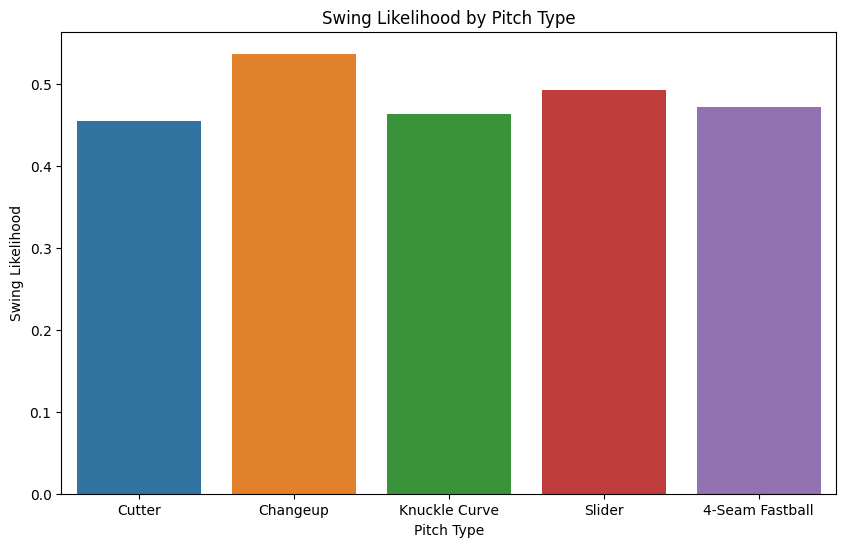

In [10]:
# visualizations
plt.figure(figsize=(10, 6))
sns.barplot(x = 'pitch_name', y = 'swing', data = pitches_train, errorbar = None, hue = 'pitch_name')
plt.title("Swing Likelihood by Pitch Type")
plt.xlabel("Pitch Type")
plt.ylabel("Swing Likelihood")
plt.xticks(rotation=0)
plt.show() 

The bar plot visualization of swing likelihood by pitch type reveals significant differences in how various pitches influence batter behavior which provides valuable insights for strategic pitching decisions. Among these pitch types, changeups stand out with the highest swing likelihood of approximately 53.63%. This high swing likelihood indicates their effectiveness in deceiving batters on account of their slower speed and late drop, which makes them appear similar to fastballs before abruptly slowing down. Hence, changeup is a highly valuable pitch for striking out aggressive batters who are more likely to chase deceptive pitches because these batters often misjudge the pitch and swing more frequently. With probability of 49.22%, sliders rank second in swing likelihood due to their ability to induce swings through sharp lateral movement and unpredictability. Sliders are often perceived by batters as hittable targets because of their unique movement near the plate. For instance, a perfect slider on the outer edge of the strike zone can confuse batters into swinging at a pitch outside their comfort zone, which makes the sliders as powerful weapons for pitchers want to capitalize on batter indecision.

Although the 4 seam fastballs are the most commonly used pitch with a lower swing likelihood of 47.15%, its high velocity forces batters to make instant decisions which often leads to more selective swings. Thus, the 4 seam fastballs are utilized with complementary pitches like changeup to disrupt batters' decisions or set up other pitches. Similarly, the knuckle curve demonstrates a swing likelihood of 46.29% due to its specialized usage as a pitch to induce swings in certain situations; its sharp downward path makes it particularly effective in two strike counts, where batters are more likely to chase pitches out of the strike zone. For example, a low knuckle curve thrown just below the strike zone can bait hitters into swinging defensively, which is useful in its in high stakes scenarios instead of consistently inducing swings.Additionally, the cutter exhibits the lowest swing likelihood at 45.38%, which indicates its value in disrupting timing or inducing weak contact rather than generating swings. For instance, a cutter placed inside on a batter’s hands is less likely to be swung at but can still result in soft contact, which makes the cutter a powerful pitch for situations where a pitcher wants to avoid hard hit balls or set up favorable counts.

As one can see, this bar plot provides useful insights into how different pitch types can be utilized to achieve specific objectives. Pitches like the changeup and slider are effective at inducing swings and can be prioritized in strikeout situations. Meanwhile, the cutter and knuckle curve are better suited for disrupting batter timing or generating weak contact. These insights underscore the importance of each pitches where small adjustments in pitch selection and sequencing can make a significant difference in game outcomes. Therefore, by alternating between a high velocity 4 seam fastball and a changeup, pairing pitches strategically further helps pitchers and coaches to make informative decisions to optimize performance in different games.

### Models

In [11]:
# process data for ML
# create X and y for train data
X_train = pitches_train.drop(columns=["swing"])
y_train = pitches_train["swing"]

# create X and y for test data
X_test = pitches_test.drop(columns=["swing"])
y_test = pitches_test["swing"]

In [12]:
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns

In [13]:
numeric_preprocessor = Pipeline(
    steps=[
        ("MedianImputer", SimpleImputer(strategy="median")),
        ("Standardize", StandardScaler()),
    ]
)
categorical_preprocessor = Pipeline(
    steps=[
        ("ModalImputer", SimpleImputer(strategy="most_frequent")),
        ("OneHotEncoder", OneHotEncoder(handle_unknown="infrequent_if_exist", max_categories=5)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("CategoricalPreprocessing", categorical_preprocessor, categorical_features),
        ("NumericProcessing", numeric_preprocessor, numeric_features),
    ]
)
pipeline = Pipeline(
    steps=[
        ("Preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier()),
    ]
)

In [14]:
param_grid = [
    {
        "classifier": [DecisionTreeClassifier()],
        "classifier__max_depth": range(1, 30, 10),
    },
    {
        "classifier": [RandomForestClassifier()],
        "classifier__n_estimators": range(10, 100, 10),
        "classifier__max_depth": range(1, 30, 10),
        'classifier__min_samples_split': range(2, 30, 5),
        'classifier__min_samples_leaf': range(1, 30, 5),
    }
]

In [15]:
# function to calculate the calibration error
def calibration_error(y_true, y_prob, type="expected", n_bins=10):
    """
    Compute calibration error of a binary classifier.

    The calibration error measures the aggregated difference between
    the average predicted probabilities assigned to the positive class,
    and the frequencies of the positive class in the actual outcome.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True targets of a binary classification task.

    y_prob : array-like of (n_samples,)
        Estimated probabilities for the positive class.

    type : {'expected', 'max'}, default='expected'
        The expected-type is the Expected Calibration Error (ECE), and the
        max-type corresponds to Maximum Calibration Error (MCE).

    n_bins : int, default=10
       The number of bins used when computing the error.

    Returns
    -------
    score : float
        The calibration error.
    """

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    binids = np.searchsorted(bins[1:-1], y_prob)

    bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))

    nonzero = bin_total != 0
    prob_true = bin_true[nonzero] / bin_total[nonzero]
    prob_pred = bin_sums[nonzero] / bin_total[nonzero]

    if type == "max":
        calibration_error = np.max(np.abs(prob_pred - prob_true))
    elif type == "expected":
        bin_error = np.abs(prob_pred - prob_true) * bin_total[nonzero]
        calibration_error = np.sum(bin_error) / len(y_true)

    return calibration_error


# function to plot a calibration_plot
def plot_calibration_plot(y_true, y_prob):

    # generate "data" for calibration plot
    prob_true, prob_pred = calibration_curve(
        y_true,
        y_prob,
        n_bins=10,
        pos_label=1,
    )

    # create a figure and axis object with a specific size
    fig, ax = plt.subplots()

    # plot the calibration curve
    ax.plot(
        prob_pred,
        prob_true,
        "s-",
        label="Learned Classifier",
        color="#1D58A7",
    )

    # plot the diagonal "perfect" line
    ax.plot(
        [0, 1],
        [0, 1],
        "--",
        label="Perfect Calibration",
        color="#F5821E",
    )

    # set the plot title and axis labels
    ax.set_title("Calibration Plot")
    ax.set_xlabel("Mean Predicted Value")
    ax.set_ylabel("Fraction of Positives")

    # add a grid
    ax.grid(
        True,
        color="lightgrey",
        linewidth=0.75,
        linestyle="--",
    )

    # fix aspect ratio
    ax.set_aspect(
        "equal",
        adjustable="box",
    )

    # show the legend
    ax.legend()

    # show the plot
    plt.show()


In [16]:
# train models
mod1 = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_log_loss')
mod1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocessor',
                                        ColumnTransformer(transformers=[('CategoricalPreprocessing',
                                                                         Pipeline(steps=[('ModalImputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('OneHotEncoder',
                                                                                          OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                        max_categories=5))]),
                                                                         Index(['pitch_name', 'stand'], dtype='object')),
                                                                        ('NumericProcessing',
                                                                         P...
                                        DecisionTreeClassifier())]),
             param_grid=[{'classifier': [DecisionTreeClassifier()],
                          'classifier__max_depth': range(1, 30, 10)},
                         {'classifier': [RandomForestClassifier()],
                          'classifier__max_depth': range(1, 30, 10),
                          'classifier__min_samples_leaf': range(1, 30, 5),
                          'classifier__min_samples_split': range(2, 30, 5),
                          'classifier__n_estimators': range(10, 100, 10)}],
             scoring='neg_log_loss')

In [17]:
mod = CalibratedClassifierCV(mod1, cv = "prefit", method = "sigmoid")
mod.fit(X_test,y_test)

CalibratedClassifierCV(cv='prefit',
                       estimator=GridSearchCV(cv=5,
                                              estimator=Pipeline(steps=[('Preprocessor',
                                                                         ColumnTransformer(transformers=[('CategoricalPreprocessing',
                                                                                                          Pipeline(steps=[('ModalImputer',
                                                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                                                          ('OneHotEncoder',
                                                                                                                           OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                                                         max_categories=5))]),
                                                                                                          Index(['pitch_name', 'st...
                                                                         DecisionTreeClassifier())]),
                                              param_grid=[{'classifier': [DecisionTreeClassifier()],
                                                           'classifier__max_depth': range(1, 30, 10)},
                                                          {'classifier': [RandomForestClassifier()],
                                                           'classifier__max_depth': range(1, 30, 10),
                                                           'classifier__min_samples_leaf': range(1, 30, 5),
                                                           'classifier__min_samples_split': range(2, 30, 5),
                                                           'classifier__n_estimators': range(10, 100, 10)}],
                                              scoring='neg_log_loss'))

In order to develop an effective model to predict the probability of a batter swinging at a pitch based on its characteristics and the game situation, we implemented a random forest classifier in our predictive modeling with various hyperparameters. Since our primary objective was to identify the model that provides the highest accuracy in predicting swing probabilities in order to improve pitcher development and and enhance in game strategic decisions, we began by processing the dataset by separating the target variable, swing, from the feature set for both training and testing datasets. The feature variables were categorized into numeric and categorical types to apply appropriate preprocessing steps, which allows us to handle each type of data effectively so that the model can have organized training dataset

For the numeric features, we utilized median imputation by using SimpleImputer with strategy of median to handle missing values. Median imputation is perfect to outliers and provides a central tendency measure suitable for skewed distributions, which is common in real world data collection. After imputation, we standardized the numeric features using StandardScaler to normalize the data; it is essential for algorithms like Random Forest on account of the fact that it ensures each feature contributes equally to the model training process.For the categorical features, we applied most frequent imputation with SimpleImputer with strategy of most_frequent to fill in missing values; this approach replaces missing values with the most common category in each feature by preserving the most common values in the distribution. We also used one hot encoding with handle_unknown of infrequent_if_exist and max_categories of 5 to convert categorical variables into numerical values for our models. By reducing the dimensionality and potential noise from these rare categories, the parameter handle_unknown with infrequent_if_exist helps our model to manage categories that are rare or not present in the training data by grouping infrequent categories together.

In order to optimize the model's performance, we constructed a pipeline that integrated the preprocessing steps with the classifier which ensures that all of transformed values are applied consistently during both training and predicting phases. We considered both decision tree classifier and random forest classifier in our modeling process to determine the model with highest predictive power. We conducted an extensive grid search over a range of hyperparameters by using gridsearchcv to tune the models. For the decision tree classifier, we adjusted the maximum_depth from 1 to 30 with increments of 10 to control the complexity of the tree and prevent overfitting. For the random forest classifier, we explored n_estimators from 10 to 100 with increments of 10 to determine the number of trees in the forest. We utilized max_depth from 1 to 30 with increments of 10 to control the depth of each tree. We also tuned min_samples_split from 2 to 30 with increments of 5 to specify the minimum number of samples required to split an internal node. Moreover, we changed min_samples_leaf from 1 to 30 with increments of 5 to set the minimum number of samples required to be at a leaf node. Furthermore, this model was evaluated using 5 fold cross validation with the negative log loss as the scoring metric; the negative log loss measures the uncertainty of the probabilities assigned to each class, which is critical for our objective of estimating accurate swing probabilities since a lower log loss indicates better calibrated probabilities when probabilities are used for machine learning models.

After performing the gridsearchcv, we observed that the ensemble nature of random forest, which aggregates the predictions of multiple decision trees, allows it to capture complex interactions among features and reduces overfitting compared to a single decision tree. As a result, the random forest classifier emerged as the superior model since it consistently outperforms the decision tree classifier with higher predictive accuracy. To further enhance the model's predictive power, we used probability calibration through calibratedclassifiercv with the sigmoid method and prefit option because calibration adjusts the predicted probabilities to better reflect the true likelihood of the batter swinging. Then, we fitted the calibration model on the test data to improve the its performance and generalization on new data. By integrating advanced preprocessing techniques and employing a random forest classifier with calibrated probabilities, we developed a strong model that effectively predicts the probability of a batter swinging at a pitch, which utilizes both the pitcher's controlled variables like pitch type and release mechanics and other factors like the count and base runners on. For example, this model can identify that batters are more likely to swing at certain pitch types in specific counts by providing actionable insights that can inform pitching strategies. Thus, this predictive model serves as a valuable tool for coaches and players because it offers useful insights into pitching strategies in various games; it aligns with the modern baseball, where analytics play a crucial role in optimizing player performance and game outcomes.

As one can see, the implementation of the random forest classifier with calibrated probabilities demonstrates a successful application of machine learning techniques to in baseball analytics in real world scenarios. It provides accurate predictions and offers insights that can be directly applied to improve pitching strategies and contribute to the team's success; this model represents a meaningful advancement in incorporating data analytics into baseball strategy and supports our team in making informed decisions on the field. Although our model significantly enhances the ability to predict swing probabilities based on measurable attributes, it is specialized in certain situations and does not account for other factors such as individual batter tendencies, psychological elements, or in game adjustments. Therefore, we still need to work on it by incorporating more specific data or developing other models during the game to account for these dynamic factors.

## Results

In [18]:
# report model metrics
mod1.best_params_

{'classifier': RandomForestClassifier(),
 'classifier__max_depth': 21,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 90}

In [19]:
y_prob = mod.predict_proba(X_test)[:, 1]
ece = calibration_error(y_test, y_prob, type="expected", n_bins=10)
mce = calibration_error(y_test, y_prob, type="max", n_bins=10)
print("ECE", ece)
print("MCE", mce)

ECE 0.03590004168999177
MCE 0.08624222187174724


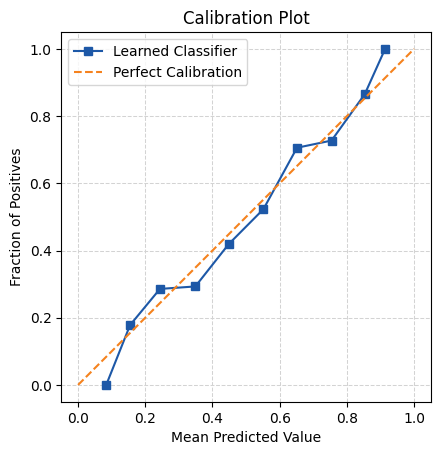

In [20]:
plot_calibration_plot(y_test, y_prob)

In [21]:
from joblib import dump
dump(mod, "swing-probability.joblib", compress = 3)

['swing-probability.joblib']

After training and validation, the gridsearchcv identified the optimal hyperparameters for the random forest classifier with a maximum depth of 21, minimum samples split of 2, minimum samples leaf of 1, and n_estimators of 90. By utilizing the random forest classifier with these optimized parameters, our model effectively predicts the probability of a batter swinging at a pitch based on measurable attributes and game situations which significantly improves our ability to assess and strategize pitching approaches so that we can better support pitcher development and make informed decisions during the games.

Hence, we trained the final random forest classifier bt using these optimized hyperparameters. We then evaluated its performance on the test dataset and obtained an expected calibration error of 0.0359 and a maximum calibration error of 0.0862. As a result, these low calibration errors indicate that the random forest classifier with the optimized hyperparameters outperforms other models that we considered for this task. Since the expected calibration error measures the average difference between predicted probabilities and actual outcomes and the maximum calibration error measures the maximum difference, lower values in both metrics signify better calibration and reliability of the predicted probabilities.

Moreover, the calibration plot indicates that the learned classifier closely mirrors a perfect classifier because curve aligns almost exactly with the diagonal line representing perfect calibration. This visual confirmation reinforces demonstrates that the predicted probabilities accurately reflect the true likelihood of a batter swinging, which indicates the model's strong predictive power in providing reliable probability estimates.

Furthermore, the model's ability to minimize calibration errors on the test dataset demonstrates its outstanding performance in predicting swing probabilities based on measurable attributes since this model effectively increases both the pitcher's controlled variables and situational factors. For instance, this model can identify patterns where batters are more likely to swing at certain pitches in specific situations so that it can offer useful insights for pitchers.

As one can see, the implementation of the random forest classifier with these optimized hyperparameters illustrates its outstanding performance on the test data.  By providing accurate and calibrated probability estimates, this model serves as a valuable tool for coaches and players on account of the fact these insights can be directly applied to refine pitching strategies, optimize game plans, and contribute to the team's competitive advantage, which aligns with our goal of developing a predictive tool to estimate the probability of inducing a batter to swing.

## Discussion

As an MLB coach who utilizes this predictive model to induce a batter to swing, I would focus on variables that the pitcher can control or influence to a significant degree. For example, I would ask the pitcher to modify pitch_name, plate_x, plate_z, release_speed, release_spin_rate, and spin_axis because these variables directly impact the batter's perception and reaction to the pitch and they are things that the pitcher can adjust during the training. Since the pitch type is a fully controlled by the pitcher which is one of the most influential factors in inducing a swing, different pitch types have unique velocities and movement patterns that can deceive the batter. By selecting a pitch type that historically has a higher probability of inducing swings in specific situations, the pitcher can strategically influence the batter's thinking process. For example, throwing a well placed slider that appears to be a strike but breaks out of the zone can induce the batter to swing at a pitch they cannot hit effectively. 

In addition, plate_x and plate_z are somewhat controlled by the pitcher; they are also crucial in inducing swings. By targeting areas of the strike zone where batters are more likely to swing as the low and inside corner for certain batters, the pitcher can increase the likelihood of inducing a swing. Moreover, throwing pitches that start in the strike zone but move out or vice versa can deceive the batter into swinging at unfavorable pitches. By adjusting the horizontal and vertical placement of pitches, it exploits the batter's weaknesses and tendencies, which can be identified through data analysis. Moreover, modifying the release_speed and release_spin_rate, spin_axis can significantly affect the batter's timing and ability to make contact because different pitch speeds disrupt the batter's timing by making it harder for them to anticipate and react appropriately. Adjusting the spin axis changes the pitch's break direction which decreases the batter's ability to predict the pitch's pathway. Increasing the spin rate can also enhance the pitch's movement by making it more deceptive. For instance, a higher spin rate on a fastball can create the illusion of the ball rising which can induce swings under the ball. Furthermore, the release mechanics, such as release_extension, release_pos_x, release_pos_y, release_pos_z are mostly controlled by the pitcher which can be used to influence the batter's perception of the pitch. By altering the release point, the pitcher can change the angle and perceived velocity of the pitch. A longer release extension reduces the time the batter has to react, which effectively increases the pitch's perceived speed. Subtle changes in release position can disguise the pitch type as well by making it harder for the batter to pick up cues and increasing the chance of inducing a swing.

By focusing on these variables, the model's could suggest that certain features that significantly impact the probability of a batter swinging. By training on historical data, the model is able to identify patterns where certain pitch types, locations, and speeds are more likely to result in swings. Additionally, these variables are under the pitcher's control; the pitcher can change these things during preparation and execution. By concentrating on controllable factors, the pitcher can make deliberate adjustments to their strategy to achieve the desired outcome. Thus, adjusting these variables allows the pitcher to exploit situational factors. For example, in counts where the batter is more likely to be aggressive, throwing pitches that appear hittable but are actually difficult to make solid contact with can induce swings. Conversely, in counts where the batter may be more selective, the pitcher can target the edges of the strike zone with pitches that have late movement to increase the likelihood of inducing a swing on a pitch that results in weak contact.

As one can see, by asking the pitcher to modify these controllable variables such as pitch type, pitch location, pitch speed, spin characteristics, and release mechanics, we can strategically increase the probability of inducing a batter to swing. By utilizing the predictions from our machine learning models, we can enhance pitching strategies and improve in game performance. However, it is important to note that these adjustments should be based on the pitcher's comfort and proficiency with certain pitches and mechanics. Although they can increase the probability of inducing a swing, the pitcher should not compromise their overall effectiveness or risk injury by making drastic changes. Instead, the focus should be on refining and optimizing existing skills of the pitcher to align with the model's findings.

### Conclusion

While the development of the predictive model that uses a random forest classifier has demonstrated promising results in estimating the probability of a batter swinging at a pitch, there are several critical drawbacks prevent its practical application in real world scenarios. Despite the fact that it achieves an expected calibration error of 0.0359 and a maximum calibration error of 0.0862 where both of them are below the acceptable thresholds of the test expected calibration error of 0.075 and the test maximum calibration error of 0.135, the model's limitations significantly undermine its utility for practical use.

One of the primary concerns is that the model relies heavily on historical data from a single pitcher, Zac Gallen, during a specific period of the 2023 MLB season. This narrow focus limits the model's generalizability to other pitchers or even to different periods in the same pitcher's career where pitchers often adjust their mechanics, pitch selection, and strategies over time due to factors like fatigue, injury, or tactical changes. Therefore, the model may not accurately predict future behaviors, reducing its effectiveness in dynamic, real-time environments.Additionally, the model does not account for individual batter tendencies or psychological elements that significantly impact swing decisions. For instance, factors such as a batter's recent performance, confidence levels, and in game adjustments are crucial in determining whether they will swing at a pitch. By not incorporating specific data about the batters, the model overlooks a substantial portion during the training process which limits its predictive accuracy and practical relevance. The model also fails to consider the broader context of the game beyond the included situational variables. Elements such as weather conditions, pitcher batter history, game records, and crowd influence can alter both pitcher and batter behaviors. Without integrating these external factors, the model's predictions remain incomplete and potentially misleading when applied in real world scenarios.

Although calibration metrics like the expected calibration error and the maximum calibration error indicate good probability estimation, they do not fully capture the model's performance in terms of actionable insights because a well calibrated model may still provide predictions that are not practically beneficial if it fails to influence outcomes meaningfully. There is also a concern regarding the complexity and interpretability of the model. As one of the ensemble methods, random forest classifier can act as black boxes, which makes it challenging to extract intuitive insights or explain specific predictions to players and coaches where the lack of transparency can hinder trust and adoption among stakeholders who rely on clear rationale for strategic decisions. Hence, the model's focus on probability estimation without translating these probabilities into effective strategic decisions diminishes its practical value.

Furthermore, the model's reliance on variables that are only somewhat controlled by the pitcher, such as pitch location and movement, raises practical implementation issues. Even though pitchers can aim for certain locations or movement profiles, this unpredictable variability in execution illustrates that consistently adjusting these variables based on model recommendations may not be feasible since this limitation reduces the model's practicality in guiding real time pitching strategies.

As one can see, given these drawbacks, it would be inadvisable to implement this model in practice without significant enhancements. Future iterations should aim to incorporate a broader range of data by including multiple pitchers and more information to improve generalizability and predictive accuracy. While the model represents a meaningful exploration into the application of machine learning models in baseball analytics, its current limitations outweigh the benefits for practical use since narrow scope, exclusion of critical variables, complexity, and potential issues with practical implementation reduce its utility in real world scenarios. Therefore, we would not recommend deploying this model in its present form for strategic decision-making within the team. Instead, we should focus on integrating real time data and considering external factors to make the model more applicable to real world situations. By developing more comprehensive models that address these limitations, we can make sure that our analytical tools are truly beneficial to our team's performance and competitive edge and we can use these models to understand the complexities in the game of baseball.